In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd

from fsvc_watermarking import fsvc_watermark_embedding, fsvc_watermark_detection
from patchwork_watermarking import patchwork_watermark_embedding, patchwork_watermark_detection
from norm_space_watermarking import norm_space_watermark_embedding, norm_space_watermark_detection
from dct_watermarking import get_watermark_length, dctb1_watermark_embedding, dctb1_watermark_detection
import warnings
warnings.filterwarnings("ignore")

# Audio Watermarking
## Proyecto N°2 Procesamiento de Voz 

Autores:
- Pablo Smolkin
- Francisco Ledesma

## ¿Qué es el watermarking?
En términos generales, es un proceso que involucra modificar el contenido de un archivo, de forma perceptible o no perceptible, con el objetivo de dar información sobre el dueño del mismo o de protegerlo contra copias no autorizadas.

El caso más popular es el de las imágenes, donde se suele agregar texto sobre la imagen de forma que no sea removible fácilmente sin alterar de forma notable el contenido deseado.

En el caso de audio, el watermarking se puede realizar agregando información a la señal original, de forma que no sea perceptible para el oído humano, pero que pueda ser detectado por un algoritmo. De esta forma, si bien no actúa como una barrera perceptible contra la copia, sí permite detectar el uso de material protegido.

## Metricas
Las métricas utilizadas para cuantizar la calidad de una técnica de watermarking son similares a las usadas para evaluar otros métodos de síntesis de audio, en términos de la calidad del sonido. Es decir, métricas objetivas como el SNR, y métricas subjetivas como el MOS o PESQ.

Además, se deben evaluar características respecto de la información transmitida. La capacidad de transmisión se puede medir con la tasa de error de bits (BER). La robustez refiere a la posibilidad de detección del watermark frente a ataques comunes como agregado de ruido, filtrado, o compresión. La seguridad refiere a la dificultad de detectar el watermark sin autorización.

En la evaluación de las implementaciones de este proyecto, se utilizarán las métricas de SNR y BER, y se tendrá en cuenta la calidad perceptual, asumiendo un entorno libre de ruido o ataques.

### Bit Error Rate

\begin{equation*}
BER = \frac{1}{N} \sum_{i=1}^{N} w_i \oplus \hat{w}_i
\end{equation*}

* N es el número total de bits en la marca de agua.
* $w_i$ es el i-ésimo bit de la secuencia original.
* $\hat{w}_i$ es el i-ésimo bit de la secuencia detectada.
* La función a $\oplus$ b devolvera un arreglo con tantos 1's como bits distintos haya.


### Signal to Noise Ratio

\begin{equation*}
SNR = 10 \log_{10}\left(\frac{\sum_{i=1}^{N} s_i^2}{\sum_{i=1}^{N} (s_i - \hat{s}_i)^2}\right)
\end{equation*}

In [2]:
def calculate_ber(watermark, watermark_detected):
  return np.sum(watermark != watermark_detected)/len(watermark)

# following function calculate the SNR from the original and watermarked signal
def calculate_snr(original_signal, watermarked_signal):
  noise = original_signal - watermarked_signal
  return 10*np.log10(np.sum(original_signal**2)/np.sum(noise**2))

In [3]:
# dictionary to compare the different watermarking methods
watermarking_methods = {
    'patchwork': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'norm_space': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'dct': {
        'SNR [dB]': 0,
        'BER [%]': 0
    }
}

In [4]:
# Import recorded speech signals
fs_hamlet, hamlet_en = wavfile.read('audios/Hamlet.wav')
hamlet_en = np.mean(hamlet_en, axis=1)
t_hamlet = np.arange(0, 4, 1/fs_hamlet)
print('Hamlet.wav: ', hamlet_en.shape, fs_hamlet)
Audio(hamlet_en, rate=fs_hamlet)

Hamlet.wav:  (176400,) 44100


## Implementaciones evaluadas
A continuación se encuentran las pruebas realizadas con tres implementaciones distintas de watermarking. Cada una fue propuesta en un paper distinto, y se le asignarán nombres particulares para poder diferenciarlas en la presentación.

* **Implementación 1**: Propuesta en el paper "Robust, transparent and high-capacity audio watermarking in DCT domain". En particular, la técnica de embedding en la primera banda de coeficientes.
* **Implementación 2**: Propuesta en el paper "Patchwork-Based Multilayer Audio Watermarking". En particular, la técnica de embedding en la primera capa.
* **Implementación 3**: Propuesta en el paper "Novel secured scheme for blind audio/speech norm-space watermarking by Arnold algorithm".

### DCT

Explicacion DCT
explicar parametros

tono puro 440

In [5]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 44100
t = np.arange(0, 8, 1/fs)
test_signal = np.sin(2*np.pi*440*t)

In [6]:
# Parameters
lt = 64
lw = 4096
lG1 = 48
lG2 = 8
band_size = lG1+lG2

# Create watermark
watermark_lenght_dct = get_watermark_length(signal=test_signal, lt=lt, lw=lw, lG1=lG1)
watermark_dct = np.tile(np.array([1, 0]), watermark_lenght_dct//2)

# Embed watermark
watermarked_signal_dct, G1_inds = dctb1_watermark_embedding(signal=test_signal, watermark=watermark_dct, sr=fs, lt=lt, lw=lw, band_size=band_size, lG1=lG1, lG2=lG2)

# Detect watermark
detected_watermark_dct = dctb1_watermark_detection(watermarked_signal=watermarked_signal_dct, sr=fs, G1_inds=G1_inds, lt=lt, lw=lw, band_size=band_size)

print(f"BER = {calculate_ber(watermark_dct, detected_watermark_dct)*100:.2f}%")

BER = 0.17%


In [7]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [8]:
# Play watermarked signal
Audio(data=watermarked_signal_dct, rate=fs)

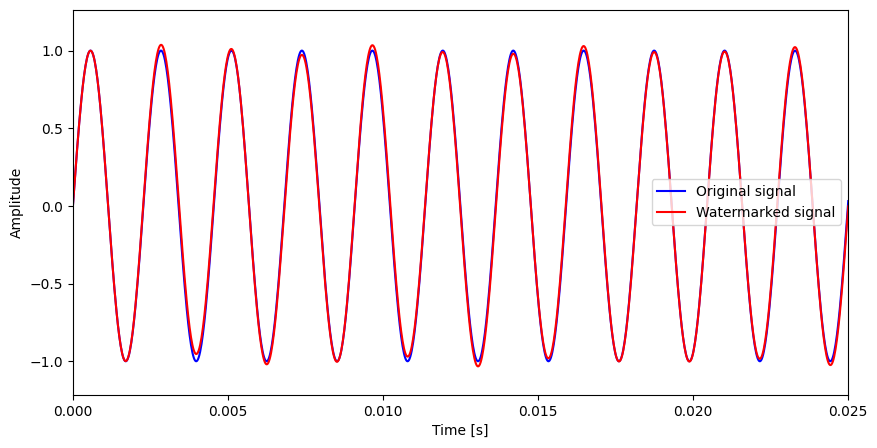

In [9]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_dct, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

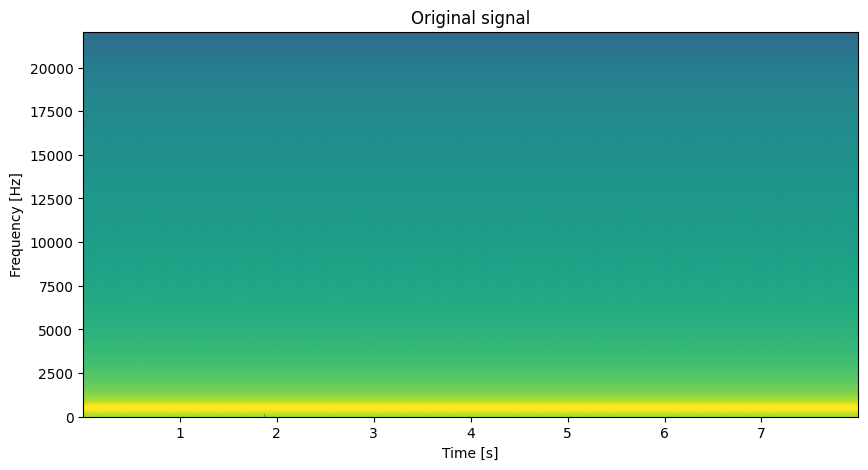

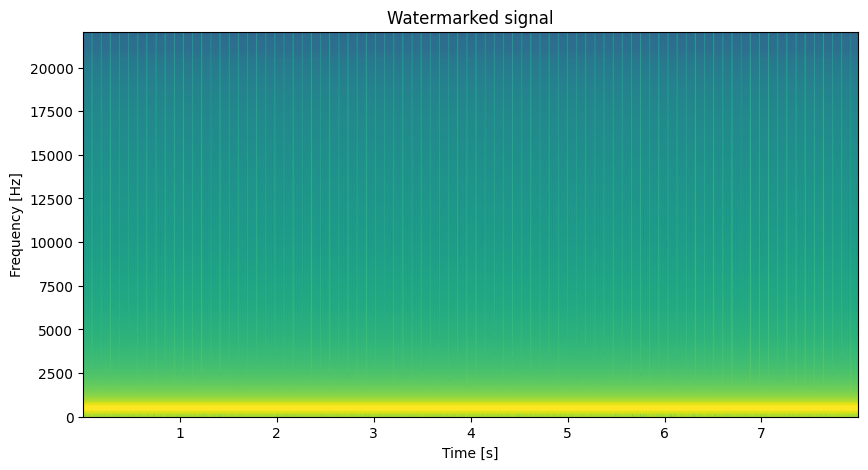

In [10]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_dct, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

hamlet -> convertir a 44100

In [11]:
# Parameters
lt = 64
lw = 4096
lG1 = 48
lG2 = 8
band_size = lG1+lG2

# Create watermark
watermark_lenght_dct = get_watermark_length(signal=hamlet_en, lt=lt, lw=lw, lG1=lG1)
watermark_dct = np.tile(np.array([1, 0]), watermark_lenght_dct//2)

# Embed watermark
watermarked_signal_dct, G1_inds = dctb1_watermark_embedding(signal=hamlet_en, watermark=watermark_dct, sr=fs, lt=lt, lw=lw, band_size=band_size, lG1=lG1, lG2=lG2)

# Detect watermark
detected_watermark_dct = dctb1_watermark_detection(watermarked_signal=watermarked_signal_dct, sr=fs_hamlet, G1_inds=G1_inds, lt=lt, lw=lw, band_size=band_size)

print(f"BER = {calculate_ber(watermark_dct, detected_watermark_dct)*100:.2f}%")
watermarking_methods['dct']['BER [%]'] = calculate_ber(watermark_dct, detected_watermark_dct)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_dct):.2f} dB")
watermarking_methods['dct']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_dct)

BER = 0.79%
SNR = 10.22 dB


In [12]:
# Play watermarked signal
Audio(data=watermarked_signal_dct, rate=fs_hamlet)

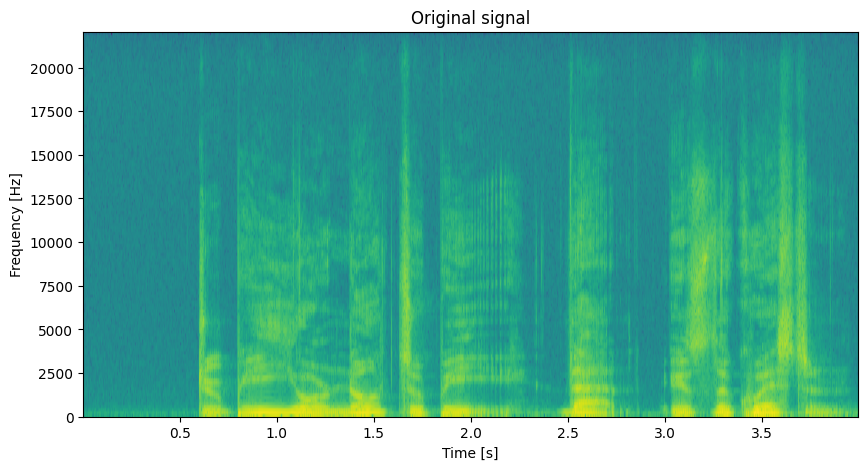

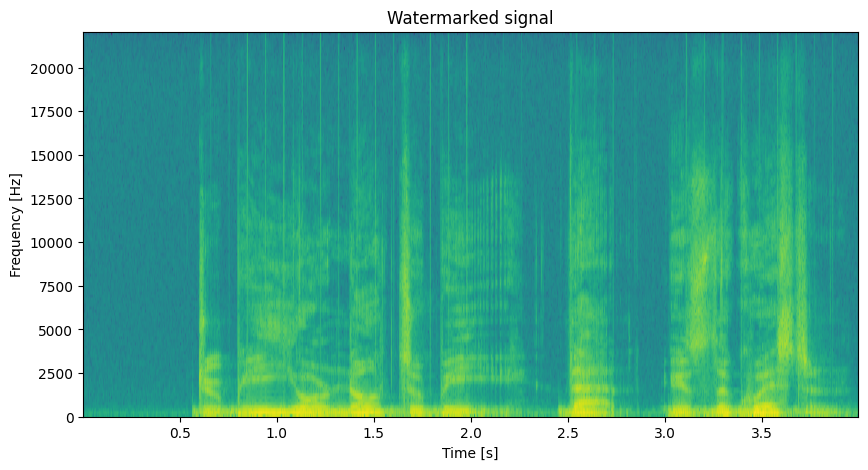

In [13]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_dct, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

### Patchwork

teoria patchwork

In [14]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 16000
t = np.arange(0, 2, 1/fs)
test_signal = np.sin(2*np.pi*500*t)

In [15]:
watermark_patch = np.tile(np.array([1, 0]), 1024)

watermarked_signal_patch = patchwork_watermark_embedding(signal=test_signal, watermark=watermark_patch, sr=fs)

detected_watermark_patch = patchwork_watermark_detection(watermarked_signal=watermarked_signal_patch, watermark_length=len(watermark_patch), sr=fs)

print(f"BER = {calculate_ber(watermark_patch, detected_watermark_patch)*100:.2f}%")

BER = 0.00%


In [16]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [17]:
# Play watermarked signal
Audio(data=watermarked_signal_patch, rate=fs)

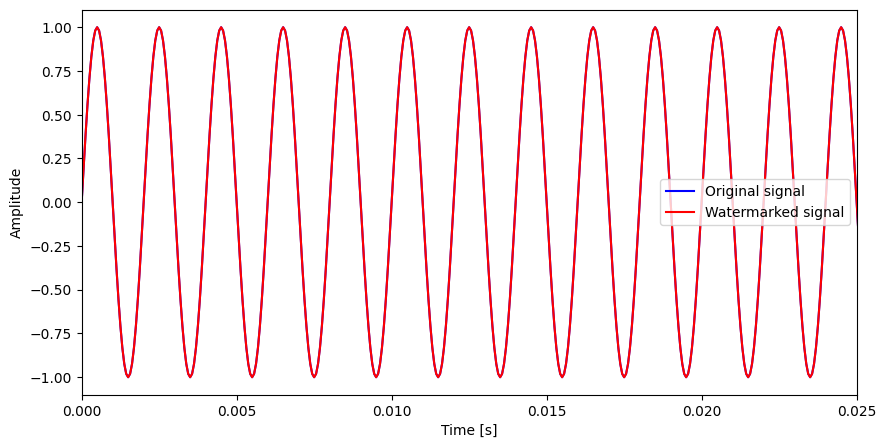

In [18]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_patch, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

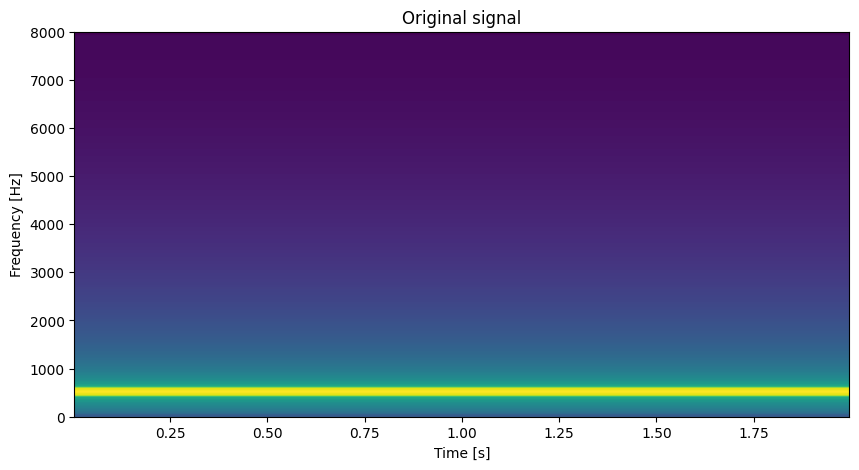

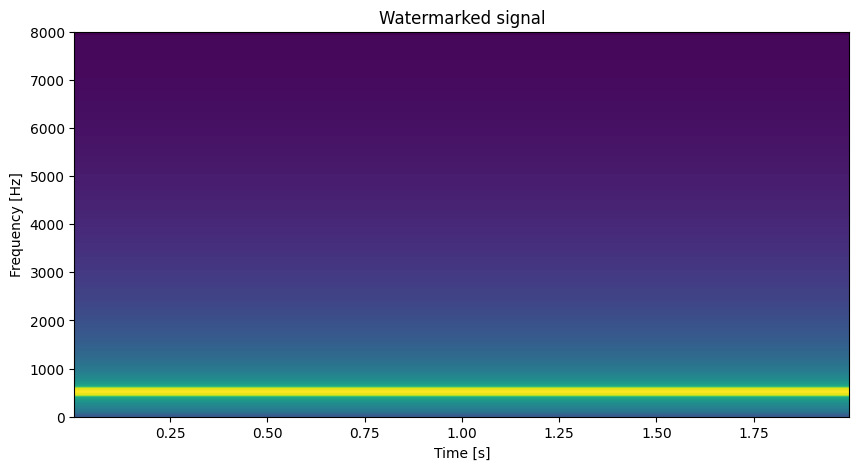

In [19]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_patch, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [20]:
watermark_patch = np.tile(np.array([1, 0]), 2**10)

watermarked_signal_patch = patchwork_watermark_embedding(signal=hamlet_en, watermark=watermark_patch, sr=fs_hamlet)

detected_watermark_patch = patchwork_watermark_detection(watermarked_signal=watermarked_signal_patch, watermark_length=len(watermark_patch), sr=fs_hamlet)

print(f"BER = {calculate_ber(watermark_patch, detected_watermark_patch)*100:.2f}%")
watermarking_methods['patchwork']['BER [%]'] = calculate_ber(watermark_patch, detected_watermark_patch)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_patch):.2f} dB")
watermarking_methods['patchwork']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_patch)

BER = 20.85%
SNR = 34.50 dB


In [21]:
Audio(hamlet_en, rate=fs_hamlet)

In [22]:
Audio(watermarked_signal_patch, rate=fs_hamlet)

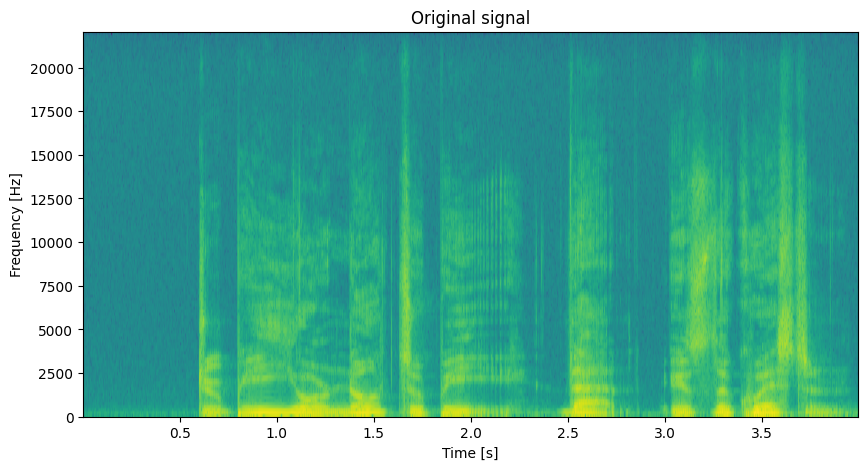

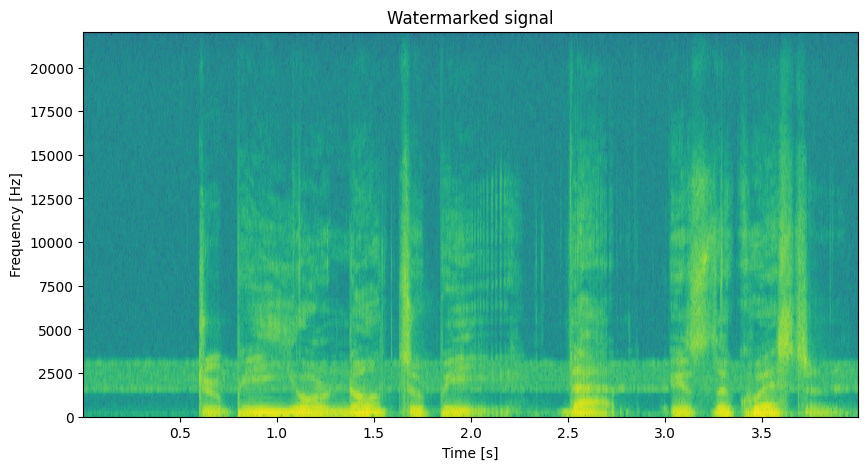

In [23]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_patch, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

### Implementación 3

La implementación de este algoritmo se puede detallar en los siguientes pasos:

**Embedding**

1. Dividir el audio original en tantos frames como bits de watermarking se quieran transmitir.
Para cada frame:
2. Aplicar un nivel de la transformada DWT, obteniendo los coeficientes cA1 (baja frecuencia, aproximación) y cD1 (alta frecuencia, detalle).
3. Aplicar la transformada DCT a los coeficientes cA1, y llamar al vector resultante V.
4. Descomponer V en dos subvectores, V1 y V2, de igual tamaño, tomando las muestras de indice par e impar respectivamente.
5. Aplicar la norma2 a cada subvector, y llamar a los resultados nrmv1 y nrmv2. Dividir V1 y V2 por sus normas y obtener los vectores unitarios u1 y u2.
6. Obtener el promedio entre las normas y llamarlo nrm.
7. Si el bit a transmitir es 1, nrmv1' = nrm + delta, y nrmv2' = nrm - delta. Si el bit a transmitir es 0, invertir los signos de las deltas.
8. Construir vectores V1' y V2' a partir de nrmv1' y nrmv2', multiplicando por los vectores unitarios u1 y u2.
9. Combinar ambos vectores utilizando los indices anteriores en un vector V'.
10. Aplicar la transformada inversa IDCT, obteniendo los coeficientes de aproximación modificados cA1'.
11. Aplicar la transformada inversa IDWT a los coeficientes cA1' y cD1.
12. Concatenar los frames resultantes, obteniendo una señal del largo original.

**Extracción**

1. Realizar las descomposiciones análogas al proceso de embedding.
2. Al llegar a las normas de los vectores, evaluar: si nrmv1 > nrmv2, el bit es 1, sino es 0.

Es importante notar que esta extracción se realiza de forma **ciega**, es decir, sin necesidad de información sobre el proceso de embedding.

De esta forma, el parametro _delta_ modifica la robustez del algorítmo (a mayor delta, menor probabilidad de obtener una comparación de normas con resultado erróneo), a costa de una mayor distorsión de la señal.

Escencialmente lo que se propone modificar son los coeficientes de aproximación de la primera capa de la DWT, que según el paper resultan menos perceptibles para la audición.

**Payload**

Los autores reportan que, haciéndo pruebas, consiguieron una tasa de bits de watermark transmitidos de ~40-50bps.

In [35]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 44100
t = np.arange(0, 8, 1/fs)
test_signal = np.sin(2*np.pi*440*t)

In [25]:
watermark_ns = np.tile(np.array([1, 0]), 20)

watermarked_signal_ns = norm_space_watermark_embedding(signal=test_signal, watermark=watermark_ns, delta=0.01)

detected_watermark_ns = norm_space_watermark_detection(watermarked_signal=watermarked_signal_ns, watermark_length=len(watermark_ns), delta=0.01)

print(f"BER = {calculate_ber(watermark_ns, detected_watermark_ns)*100:.2f}%")

BER = 0.00%


In [26]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [27]:
# Play watermarked signal
Audio(data=watermarked_signal_ns, rate=fs)

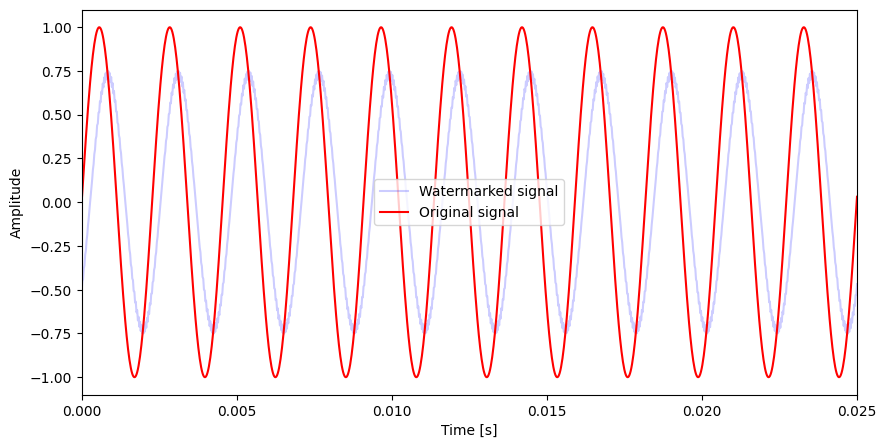

In [28]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, watermarked_signal_ns, label="Watermarked signal", color=(0.0, 0, 1.0, 0.2))
plt.plot(t, test_signal, label="Original signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

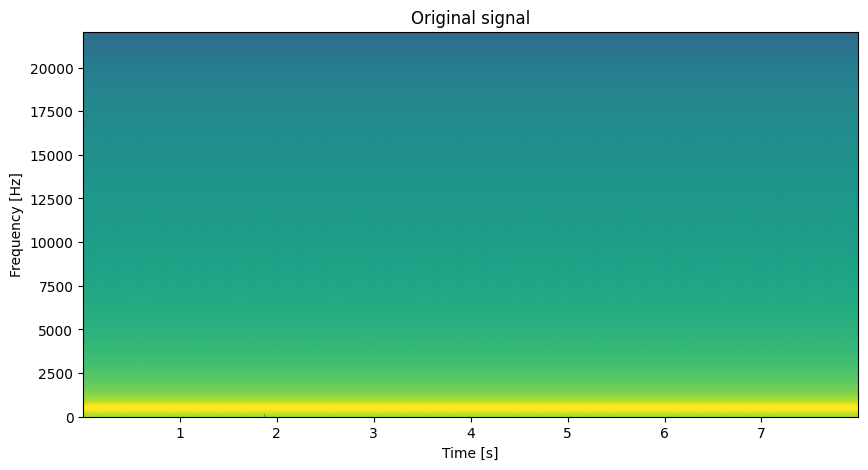

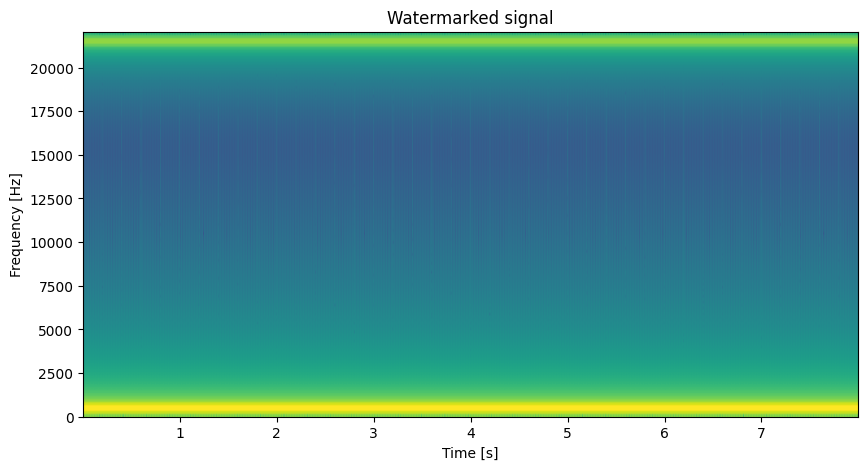

In [29]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_ns, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [30]:
watermark_ns = np.tile(np.array([1, 0]), 20)

watermarked_signal_ns = norm_space_watermark_embedding(signal=hamlet_en, watermark=watermark_ns, delta=0.01)

detected_watermark_ns = norm_space_watermark_detection(watermarked_signal=watermarked_signal_ns, watermark_length=len(watermark_ns), delta=0.01)

print(f"BER = {calculate_ber(watermark_ns, detected_watermark_ns)*100:.2f}%")
watermarking_methods['norm_space']['BER [%]'] = calculate_ber(watermark_ns, detected_watermark_ns)*100

watermarked_signal_ns[np.isnan(watermarked_signal_ns)] =  0

print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_ns):.2f} dB")
watermarking_methods['norm_space']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_ns)


BER = 0.00%
SNR = 20.41 dB


In [31]:
# Play watermarked signal
Audio(data=watermarked_signal_ns, rate=fs_hamlet)

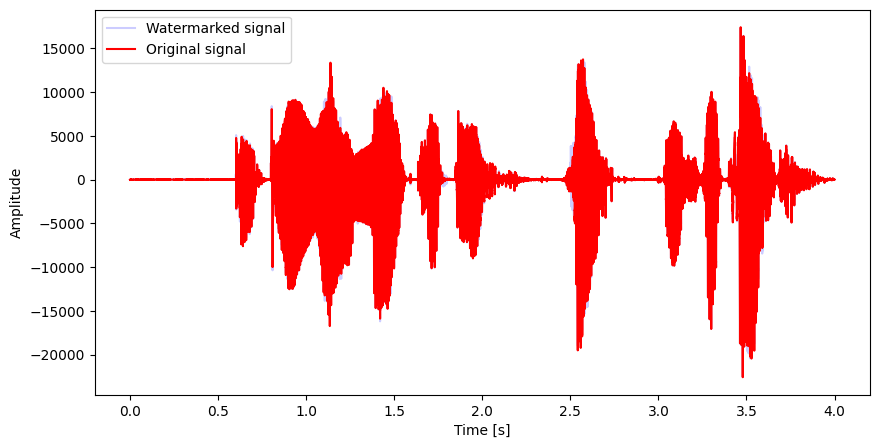

In [32]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t_hamlet, watermarked_signal_ns, label="Watermarked signal", color=(0.0, 0, 1.0, 0.2))
plt.plot(t_hamlet, hamlet_en, label="Original signal", color=(1.0, 0, 0, 1.0))
# plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

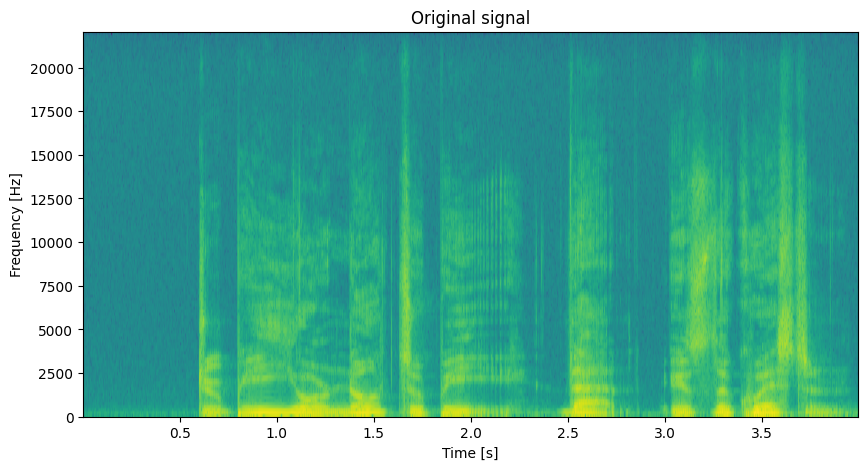

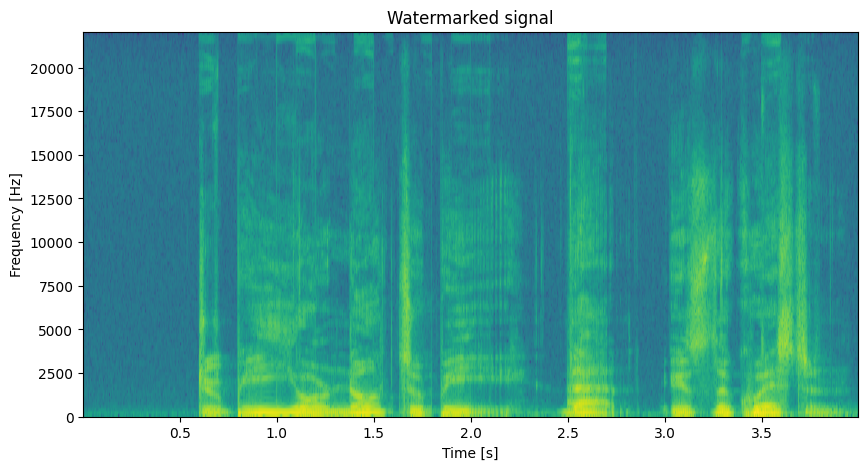

In [33]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_ns, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [34]:
watermarking_methods_df = pd.DataFrame.from_dict(watermarking_methods, orient='index')
watermarking_methods_df = watermarking_methods_df.round(2)
display(watermarking_methods_df)

SNR [dB]  BER [%]
patchwork      34.50    20.85
norm_space     20.41     0.00
dct            10.22     0.79